In [1]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# Download stock data
stock_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
specific_df = pd.DataFrame(stock_data).reset_index()


[*********************100%%**********************]  1 of 1 completed


In [4]:
# Use closing price as the target variable
target_col = 'Close'

# Feature engineering
specific_df['Date'] = pd.to_datetime(specific_df['Date'])
specific_df['Year'] = specific_df['Date'].dt.year
specific_df['Month'] = specific_df['Date'].dt.month
specific_df['Day'] = specific_df['Date'].dt.day

In [5]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(specific_df[[target_col]])


In [6]:
# Define genetic algorithm parameters
population_size = 20
num_generations = 10
mutation_rate = 0.02

In [7]:
# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]


In [8]:
# Function to generate sequences and labels for LSTM
def generate_sequences_and_labels(data, n_past):
    sequences, labels = [], []
    for i in range(len(data)-n_past):
        sequences.append(data[i:i+n_past])
        labels.append(data[i+n_past, 0])
    return np.array(sequences), np.array(labels)


In [9]:
# Set the number of past days to consider for prediction
n_past = 60
x_train, y_train = generate_sequences_and_labels(train_data, n_past)
x_test, y_test = generate_sequences_and_labels(test_data, n_past)


In [10]:
# Genetic Algorithm
def initialize_population():
    return {
        'lstm_units': np.random.randint(50, 200),
        'dropout_rate': np.random.uniform(0.2, 0.5),
        'learning_rate': 10 ** np.random.uniform(-4, -2)
    }


In [11]:
def create_lstm_model(lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=(n_past, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [12]:
def fitness(params, x_train, y_train, x_test, y_test):
    lstm_units = params['lstm_units']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']

    model = create_lstm_model(lstm_units, dropout_rate, learning_rate)

    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)

    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)

    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    # Maximize negative mean squared error
    return -test_mse

In [13]:
def mutate(params):
    for key in params.keys():
        if np.random.rand() < mutation_rate:
            if key == 'lstm_units':
                params[key] = np.random.randint(50, 200)
            elif key == 'dropout_rate':
                params[key] = np.random.uniform(0.2, 0.5)
            elif key == 'learning_rate':
                params[key] = 10 ** np.random.uniform(-4, -2)
    return params

In [14]:
def crossover(parent1, parent2):
    child = {}
    for key in parent1.keys():
        child[key] = np.random.choice([parent1[key], parent2[key]])
    return child


In [15]:
# Genetic Algorithm
population = [initialize_population() for _ in range(population_size)]


In [16]:
for generation in range(num_generations):
    fitness_scores = [fitness(params, x_train, y_train, x_test, y_test) for params in population]
    selected_indices = np.argsort(fitness_scores)[-population_size // 2:]
    selected_population = [population[i] for i in selected_indices]

    mutated_population = [mutate(params) for params in selected_population]
    crossover_indices = np.random.permutation(len(selected_population))
    offspring_population = [crossover(mutated_population[i], mutated_population[crossover_indices[i]]) for i in range(population_size // 2)]

    population = selected_population + offspring_population


5/5 [==============================] - 0s 3ms/step


In [17]:
best_params = population[np.argmax([fitness(params, x_train, y_train, x_test, y_test) for params in population])]


5/5 [==============================] - 0s 4ms/step


In [18]:
# Train the final LSTM model with the best hyperparameters
best_lstm_model = create_lstm_model(best_params['lstm_units'], best_params['dropout_rate'], best_params['learning_rate'])
best_lstm_model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
24/24 - 2s - loss: 0.0357 - 2s/epoch - 84ms/step
Epoch 2/50
24/24 - 0s - loss: 0.0046 - 173ms/epoch - 7ms/step
Epoch 3/50
24/24 - 0s - loss: 0.0030 - 155ms/epoch - 6ms/step
Epoch 4/50
24/24 - 0s - loss: 0.0025 - 159ms/epoch - 7ms/step
Epoch 5/50
24/24 - 0s - loss: 0.0026 - 157ms/epoch - 7ms/step
Epoch 6/50
24/24 - 0s - loss: 0.0023 - 152ms/epoch - 6ms/step
Epoch 7/50
24/24 - 0s - loss: 0.0021 - 152ms/epoch - 6ms/step
Epoch 8/50
24/24 - 0s - loss: 0.0021 - 157ms/epoch - 7ms/step
Epoch 9/50
24/24 - 0s - loss: 0.0021 - 158ms/epoch - 7ms/step
Epoch 10/50
24/24 - 0s - loss: 0.0021 - 154ms/epoch - 6ms/step
Epoch 11/50
24/24 - 0s - loss: 0.0020 - 163ms/epoch - 7ms/step
Epoch 12/50
24/24 - 0s - loss: 0.0021 - 167ms/epoch - 7ms/step
Epoch 13/50
24/24 - 0s - loss: 0.0019 - 144ms/epoch - 6ms/step
Epoch 14/50
24/24 - 0s - loss: 0.0017 - 126ms/epoch - 5ms/step
Epoch 15/50
24/24 - 0s - loss: 0.0018 - 118ms/epoch - 5ms/step
Epoch 16/50
24/24 - 0s - loss: 0.0020 - 115ms/epoch - 5ms/step
Epo

In [19]:
# Make predictions on the test set
test_predictions = best_lstm_model.predict(x_test)

5/5 [==============================] - 0s 4ms/step


In [20]:
# Inverse transform to get the original scale
test_predictions_inverse = scaler.inverse_transform(test_predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


In [21]:
# Evaluate the model
test_mse = mean_squared_error(y_test_inverse, test_predictions_inverse)
print(f"Test Mean Squared Error: {test_mse}")


Test Mean Squared Error: 17.9070978500162


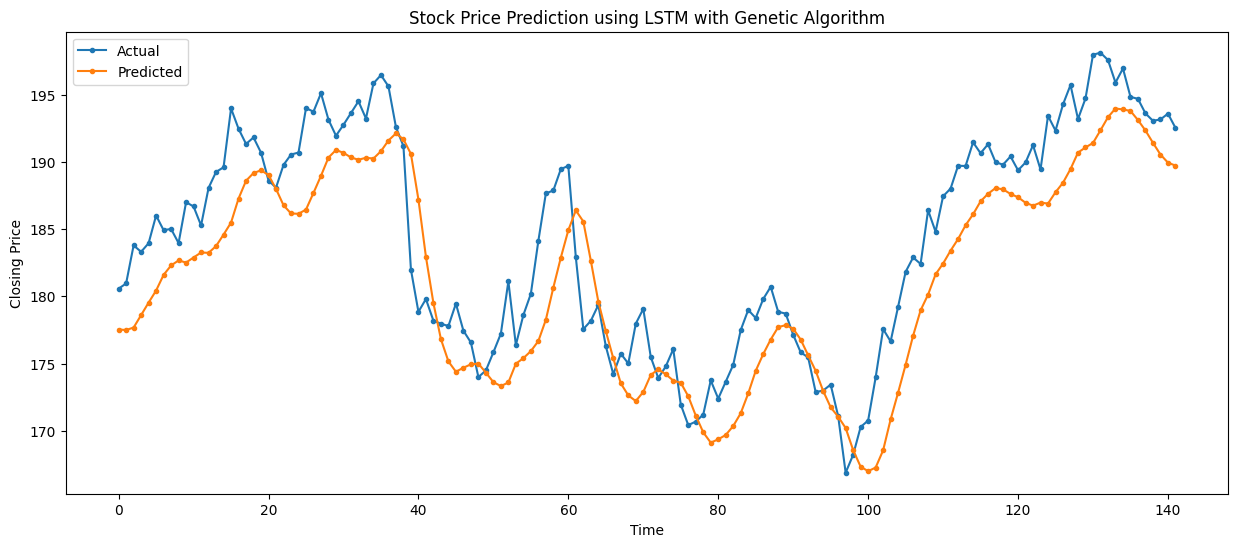

In [22]:
# Plot actual vs. predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_test_inverse, label='Actual', marker='.')
plt.plot(test_predictions_inverse, label='Predicted', marker='.')
plt.title('Stock Price Prediction using LSTM with Genetic Algorithm')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()